# Simplicial approximation to CW complexes in practice: demo

Raphaël Tinarrage, https://raphaeltinarrage.github.io/ \
December 2021

This page describes the implementation and use of the algorithm described in our paper *Simplicial approximation to CW complexes in practice*.

## Background 

The algorithm presented in this notebook has been designed to answer the following problem: given a CW complex, build a homotopy equivalent simplicial complex.

Roughly speaking, a CW complex is a topological space obtained by iteratively gluing closed balls along their boundary. An example is given in the following figure: the sphere $\mathbb{S}^2$ can be obtained from a point, by gluing the two ends of an interval, so as to obtain a circle, and then gluing two disks on it, along their boundary. This gives a filtration of $\mathbb{S}^2$ by four sets, denoted $X_0 \subset X_1 \subset X_2 \subset X_3 = \mathbb{S}^2$. The set $X_i$ is called the $i^\mathrm{th}$ skeleton.

<img src="Fig1.png" width=800 height=700 />

In this context, the balls are called *cells*. If $\bar{\mathcal{B}}^d$ denotes a closed ball of dimension $d$, then its boundary is the $(d-1)$-sphere $\mathbb{S}^{d-1}$, and the gluing of $\bar{\mathcal{B}}^d$ on $X$ is specified by a map $\phi\colon \mathbb{S}^{d-1} \rightarrow X$, called a *gluing map*. The input of our algorithm will be the collection of the gluing maps.

Following the method described in our paper, we will build inductively simplicial complexes $K_0, \dots, K_3$, and for each of them a homotopy equivalence $h_i\colon X_i \rightarrow |K_i|$, where $|K_i|$ denote the geometric realization of $K_i$.
As it turns out, $K_{i}$ can be described as $\mathrm{Cone}^\mathrm{s}(\phi_{i}')$, the *simplicial mapping cone* of $\phi_{i}'$, where $\phi_{i}'$ is a simplicial map derived from the gluing map $\phi_{i}$.
The following figure represents this process.

<img src="Fig2.png" width=800 height=700 />

## Sketch of algorithm

We suppose that the input CW complex is given as a list **Cells = [Cells[0], Cells[1], $\dots$]**.
The data structure **Cells[i]** contains all the information relative to the $i^\mathrm{th}$ cell: 
- its dimension **Cells[i].Dimension**,
- its domain **Cells[i].Domain**,
- its gluing map **Cells[i].GluingMap**,
- its inverse characteristic map **Cells[i].InvCharacteristicMap**.

The algorithm builds a sequence of simplicial complexes **Skeleta[0]**, **Skeleta[1]**, ... as follows:
- We start with **Skeleta[0]**, a complex consisting of only one point.
- From **Skeleta[i-1]**, we glue the $i^\mathrm{th}$ cell as follows: 
    - we build a triangulation of the sphere, denoted **Sphere**,
    - we subdivise this sphere until the gluing map **Cells[i].GluingMap** satisfies the weak star condition,
    - we consider a weak simplicial approximation to the gluing map.
- We then build a triangulation of the ball, denoted **Ball**, and glue it to **Skeleta[i-1]**, via the weak simplicial approximation. This gives **Skeleta[i]**.

In order to perform the subdivision process, one method has to be choosen among:
- barycentric subdivisions,
- edgewise subdivisions,
- Delaunay barycentric subdivisions or
- Delaunay edgewise subdivisions.

Moreover, the algorithm contains two optional simplification steps: the **contraction of codomain**, which contract the skeleta via repeated edge contractions, and the **Delaunay simplification**, which reduce the spheres before gluing them. This latter step is only defined for Delaunay subdivisions.

## Implementation

The algorithm can be used as follows:

```python
method_subdivision = 'Delaunay-edgewise' #can also be 'barycentric', 'edgewise' or 'Delaunay-barycentric'.
apply_contraction = True #True or False, whether to apply contractions
apply_simplification = True #True or False, whether to apply simplification (Delaunay only)

for i in range(len(Cells)):
    Cell = Cells[i]

    if Cell.Dimension == 0:
        Skeleton = TriangulatePoint()
        Skeleton.add_Domain(Cells[i].Domain)

    else:
        Sphere = TriangulateSphere(dim=Cell.Dimension-1,subdivise=Cell.Subdivise,method=method_subdivision)
        LocationMap = GetGluingLocationMap(Sphere, Skeleton, Cell.GluingMap)
        SatisfyCondition, Vertices = CheckWeakStarCondition(Sphere.Complex, Skeleton.Complex, LocationMap)
        while not SatisfyCondition:
            Sphere = GeneralizedSubdivision(Sphere, Vertices, method=method_subdivision)
            LocationMap = GetGluingLocationMap(Sphere, Skeleton, Cell.GluingMap, LocationMap)
            SatisfyCondition,Vertices = CheckWeakStarCondition(Sphere.Complex,Skeleton.Complex,LocationMap)
        if apply_simplification: Sphere,Vertices = SimplifyDelaunay(Sphere.Complex, Skeleton.Complex, Vertices, Sphere.Coordinates)
        Ball = TriangulateBall(Sphere, verbose=False)
        Skeleton = GlueCell(Ball, Skeleton, Cell, Vertices)
        if apply_contraction: Skeleton = ContractTriangulation(Skeleton)
```

Let us describe each of these functions.
- **TriangulatePoint**: returns a triangulation of the topological space consisting of only one point.
- **TriangulateSphere**: returns a triangulation of the sphere $\mathbb{S}^d$ based on an embedding of $\partial \Delta^{d+1}$, the boundary of the standard $d$-simplex, in $\mathbb{R}^{d+1}$.
- **CheckWeakStarCondition**: checks whether the map **Cells[i].GluingMap**, from **Spheres.Complex** to **Skeleton.Complex**, satisfies the weak star condition. 
If it does not, **IsSimplicial** is **False**, and **Vertices** is the list of vertices where the map does not satisfy the weak star condition. If it does, **IsSimplicial** is **True**, and **Vertices** is a dictionary representing a weak simplicial approximation.
- **GeneralizedSubdivision**: performs a generalized subdivision to the simplicial complex **Sphere.Complex**.
- **TriangulateBall**: builds the simplicial cone on **Sphere**.
- **GlueCell**: builds the simplicial mapping cone of the simplicial map **Vertices** by identifying the outer part of **Ball** with **Skeleton**.

Moreover, the optional steps are:
- **ContractTriangulation**: contracts the triangulation **Skeleton** by repeated edge contractions.
- **SimplifyDelaunay**: simplifies the simplicial map **Vertices**, following the Delaunay simplification procedure.

A diagrammatic representation of the algorithm is given in the next figure. The variables on the arrows are the output of the functions in the boxes. Optional steps are represented in dashed.
<img src="Fig3.png" width=700 height=700 />

## Experiments

We consider in this notebook the following CW complexes:
- the real projective spaces $\mathbb{R}P^n$ up to dimension $n = 3$,
- the Grassmannian of 2-planes in $\mathbb{R^4}$, $\mathcal{G}_2(\mathbb{R}^4)$.

## Functions

In [1]:
from functions import *

def PrintHomology(self):
        Primes = [2, 3]
        for p in Primes:
            barcode = self.Complex.persistence(persistence_dim_max=True, homology_coeff_field = p)
            homology = {homology_dim:0 for homology_dim in range(self.Complex.dimension()+1) }
            for interval in barcode:
                homology_dim = interval[0]
                homology[homology_dim] += 1
            msg = ['H'+repr(homology_dim)+' = '+repr(homology[homology_dim]) for homology_dim in homology ]
            msg = '  -  '.join(msg)
            msg = 'Homology over p='+repr(p)+':   '+msg
            sys.stdout.write(msg+'\n')
            
def main():            
    for i in range(len(Cells)):
        Cell = Cells[i]

        if Cell.Dimension == 0:
            Skeleton = TriangulatePoint()
            Skeleton.add_Domain(Cells[i].Domain)

        else:
            Sphere = TriangulateSphere(dim=Cell.Dimension-1,subdivise=Cell.Subdivise,method=method_subdivision)
            LocationMap = GetGluingLocationMap(Sphere, Skeleton, Cell.GluingMap)
            SatisfyCondition, Vertices = CheckWeakStarCondition(Sphere.Complex, Skeleton.Complex, LocationMap)
            while not SatisfyCondition:
                Sphere = GeneralizedSubdivision(Sphere, Vertices, method=method_subdivision)
                LocationMap = GetGluingLocationMap(Sphere, Skeleton, Cell.GluingMap, LocationMap)
                SatisfyCondition,Vertices = CheckWeakStarCondition(Sphere.Complex,Skeleton.Complex,LocationMap)
            if apply_simplification: Sphere, Vertices = SimplifyDelaunay(Sphere.Complex, Skeleton.Complex, Vertices,  Sphere.Coordinates, verbose=True)
            Ball = TriangulateBall(Sphere)
            Skeleton = GlueCell(Ball, Skeleton, Cell, Vertices)
            if apply_contraction: Skeleton = ContractTriangulation(Skeleton, verbose=True)
                
        print('Cell of dim '+repr(i)+' glued, the complex has '+repr(Skeleton.Complex.num_vertices())+' vertices.')
        PrintHomology(Skeleton)
        print()
        
    return Skeleton

# Experiment I: the real projective spaces $\mathbb{R}P^n$

## I-1: With edge contractions only

We first build the list **Cells**, that represent the data of the gluing maps of the projective spaces.
In order to ensure the termination of the algorithm, we have to perform an initial number of subdivisions on each cell. This number is prescribed by the value **Cell.Subdivise**.

In [5]:
Cells = []
Subdivise = {0:0, 1:0, 2:2, 3:2}
for i in range(len(Subdivise)):
    Cell = ClassCell()
    Cell.Dimension = i
    Cell.Subdivise = Subdivise[i]
    Cell.add_Domain(DomainProjectiveSpace)
    Cell.add_GluingMap(GluingMapProjectiveSpace)
    Cell.add_InvCharacteristicMap(InvCharacteristicMapProjectiveSpace)
    Cells.append(Cell)  

We now apply the algorithm **main()**, with edgewise subdivisions, and without edge contractions.
The last complex is a simplicial complex, with $3823$ vertices, potentially homotopy equivalent to $\mathbb{R}P^3$. In order to verify its homotopy type, further verification steps must be used. Here, we only check that it has the correct homology over $\mathbb{Z}/2\mathbb{Z}$ and $\mathbb{Z}/3\mathbb{Z}$.

In [6]:
# Edgewise subdivision, without contractions

method_subdivision = 'edgewise'
apply_contraction = False
apply_simplification = False

main();

Cell of dim 0 glued, the complex has 1 vertices.
Homology over p=2:   H0 = 1
Homology over p=3:   H0 = 1

Cell of dim 1 glued, the complex has 4 vertices.
Homology over p=2:   H0 = 1  -  H1 = 1
Homology over p=3:   H0 = 1  -  H1 = 1

Cell of dim 2 glued, the complex has 41 vertices.
Homology over p=2:   H0 = 1  -  H1 = 1  -  H2 = 1
Homology over p=3:   H0 = 1  -  H1 = 0  -  H2 = 0

Cell of dim 3 glued, the complex has 3823 vertices.
Homology over p=2:   H0 = 1  -  H1 = 1  -  H2 = 1  -  H3 = 1
Homology over p=3:   H0 = 1  -  H1 = 0  -  H2 = 0  -  H3 = 1



Next, we apply the algorithm, now using edge contractions. We obtain simplicial complexes with fewer vertices. In particular, the last one has only $114$ vertices.

In [7]:
# Edgewise subdivision, with contractions

method_subdivision = 'edgewise'
apply_contraction = True
apply_simplification = False

main();

Cell of dim 0 glued, the complex has 1 vertices.
Homology over p=2:   H0 = 1
Homology over p=3:   H0 = 1

| ContractTriangulation  | fast. Vertex 1/4. Duration 0:00:00/0:00:00. Dim/Simp/Vert = 1/6/3.
Cell of dim 1 glued, the complex has 3 vertices.
Homology over p=2:   H0 = 1  -  H1 = 1
Homology over p=3:   H0 = 1  -  H1 = 1

| ContractTriangulation  | fast. Vertex 33/40. Duration 0:00:00/0:00:00. Dim/Simp/Vert = 2/37/7.
Cell of dim 2 glued, the complex has 7 vertices.
Homology over p=2:   H0 = 1  -  H1 = 1  -  H2 = 1
Homology over p=3:   H0 = 1  -  H1 = 0  -  H2 = 0

| ContractTriangulation  | fast. Vertex 2199/2313. Duration 0:02:30/0:00:08. Dim/Simp/Vert = 3/2474/114.
Cell of dim 3 glued, the complex has 114 vertices.
Homology over p=2:   H0 = 1  -  H1 = 1  -  H2 = 1  -  H3 = 1
Homology over p=3:   H0 = 1  -  H1 = 0  -  H2 = 0  -  H3 = 1



We now apply the algorithm with barycentric subdivisions. 
In this example, it yields a last complex with $15872$ vertices, then contracted to $1325$. This is more than edgewise subdivisions.

In [8]:
# Barycentric subdivision, with contractions

method_subdivision = 'barycentric'
apply_contraction = True
apply_simplification = False

main(); #/!\ long computation time (3 hours on my laptop)

Cell of dim 0 glued, the complex has 1 vertices.
Homology over p=2:   H0 = 1
Homology over p=3:   H0 = 1

| ContractTriangulation  | fast. Vertex 1/4. Duration 0:00:00/0:00:00. Dim/Simp/Vert = 1/6/3.
Cell of dim 1 glued, the complex has 3 vertices.
Homology over p=2:   H0 = 1  -  H1 = 1
Homology over p=3:   H0 = 1  -  H1 = 1

| ContractTriangulation  | fast. Vertex 33/40. Duration 0:00:00/0:00:00. Dim/Simp/Vert = 2/37/7.
Cell of dim 2 glued, the complex has 7 vertices.
Homology over p=2:   H0 = 1  -  H1 = 1  -  H2 = 1
Homology over p=3:   H0 = 1  -  H1 = 0  -  H2 = 0

| ContractTriangulation  | fast. Vertex 14547/15872. Duration 2:46:42/0:15:10. Dim/Simp/Vert = 3/30754/1325.
Cell of dim 3 glued, the complex has 1325 vertices.
Homology over p=2:   H0 = 1  -  H1 = 1  -  H2 = 1  -  H3 = 1
Homology over p=3:   H0 = 1  -  H1 = 0  -  H2 = 0  -  H3 = 1



## I-2: With Delaunay simplifications

Using Delaunay complexes, we can use another simplification step. 
This allows significantly faster computations. We first experiment with the Delaunay-barycentric subdivisions.
The last complex has $13$ vertices.

In [9]:
# Delaunay-barycentric subdivision, with contractions and simplification

method_subdivision = 'Delaunay-barycentric'
apply_contraction = True
apply_simplification = True

main();

Cell of dim 0 glued, the complex has 1 vertices.
Homology over p=2:   H0 = 1
Homology over p=3:   H0 = 1

| SimplifyDelaunay       | Dim/Simp/Vert = 0/2/2.
| ContractTriangulation  | fast. Vertex 1/4. Duration 0:00:00/0:00:00. Dim/Simp/Vert = 1/6/3.
Cell of dim 1 glued, the complex has 3 vertices.
Homology over p=2:   H0 = 1  -  H1 = 1
Homology over p=3:   H0 = 1  -  H1 = 1

| SimplifyDelaunay       | Vertex 30/36. Duration 0:00:00/0:00:00. Dim/Simp/Vert = 1/14/7.
| ContractTriangulation  | fast. Vertex 5/11. Duration 0:00:00/0:00:00. Dim/Simp/Vert = 2/31/6.
Cell of dim 2 glued, the complex has 6 vertices.
Homology over p=2:   H0 = 1  -  H1 = 1  -  H2 = 1
Homology over p=3:   H0 = 1  -  H1 = 0  -  H2 = 0

| SimplifyDelaunay       | Vertex 1807/1882. Duration 0:00:00/0:00:00. Dim/Simp/Vert = 2/446/76.
| ContractTriangulation  | fast. Vertex 70/83. Duration 0:00:00/0:00:00. Dim/Simp/Vert = 3/238/13.
Cell of dim 3 glued, the complex has 13 vertices.
Homology over p=2:   H0 = 1  -  H1 = 1 

We now reproduce the same experiment with Delaunay-edgewise subdivisions.
We obtain a last complex with $15$ vertices.

In [10]:
# Delaunay-edgewise subdivision, with contractions and simplification

method_subdivision = 'Delaunay-edgewise'
apply_contraction = True
apply_simplification = True

Skeleton = main()

Cell of dim 0 glued, the complex has 1 vertices.
Homology over p=2:   H0 = 1
Homology over p=3:   H0 = 1

| SimplifyDelaunay       | Dim/Simp/Vert = 0/2/2.
| ContractTriangulation  | fast. Vertex 1/4. Duration 0:00:00/0:00:00. Dim/Simp/Vert = 1/6/3.
Cell of dim 1 glued, the complex has 3 vertices.
Homology over p=2:   H0 = 1  -  H1 = 1
Homology over p=3:   H0 = 1  -  H1 = 1

| SimplifyDelaunay       | Vertex 30/36. Duration 0:00:00/0:00:00. Dim/Simp/Vert = 1/14/7.
| ContractTriangulation  | fast. Vertex 5/11. Duration 0:00:00/0:00:00. Dim/Simp/Vert = 2/31/6.
Cell of dim 2 glued, the complex has 6 vertices.
Homology over p=2:   H0 = 1  -  H1 = 1  -  H2 = 1
Homology over p=3:   H0 = 1  -  H1 = 0  -  H2 = 0

| SimplifyDelaunay       | Vertex 1051/1134. Duration 0:00:00/0:00:00. Dim/Simp/Vert = 2/494/84.
| ContractTriangulation  | fast. Vertex 76/91. Duration 0:00:00/0:00:00. Dim/Simp/Vert = 3/308/15.
Cell of dim 3 glued, the complex has 15 vertices.
Homology over p=2:   H0 = 1  -  H1 = 1 

We point out that the output of this algorithm is not deterministic. Indeed, some random choices are made while choosing a weak simplicial approximation, while performing the Delaunay simplification and during edge contractions. In some cases, one obtains a last simplicial complex with only $11$ vertices, which is the minimal number of vertices of a triangulation of $\mathbb{R}P^3$

The following figure represents the last cell computed by the algorithm. It is a triangulation of the sphere. One observes that the cell has been preferentially subdivided near to a circle.

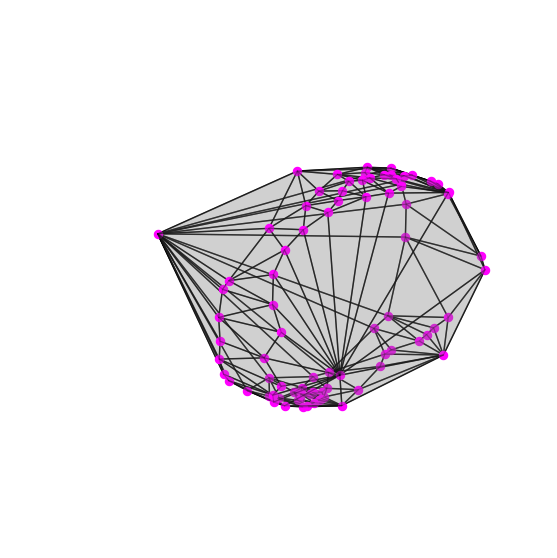

In [12]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
figsize = (10,10)

# Ball dim 3
tr = Skeleton.Parent.NewTriangulation.Boundary
Edges = (filtr[0] for filtr in tr.Complex.get_filtration() if len(filtr[0])==2)
fig = plt.figure(figsize = figsize); ax = fig.add_subplot(111, projection='3d')
X = np.array(list(tr.Coordinates.values())) 
for edge in Edges:
    ax.plot([X[edge[0]][0], X[edge[1]][0]], [X[edge[0]][1], X[edge[1]][1]], [X[edge[0]][2], X[edge[1]][2]], color='black', alpha=.9)
Triangles = (filtr[0] for filtr in tr.Complex.get_filtration() if len(filtr[0])==3)
Patches = []
for triangle in Triangles:
    verts = [tr.Coordinates[v] for v in triangle]
    ax.add_collection3d(Poly3DCollection(verts, alpha=0.2, color='grey', edgecolor='black',linewidths=1.25)) 
for i in tr.Coordinates.keys():
    ax.scatter3D(X[i, 0], X[i, 1], X[i, 2], color = 'magenta', lw = 5, alpha = 1)    
velour.set_axes_equal(ax); plt.axis('off'); plt.axis('tight');

# Experiment II: the Grassmannian $\mathcal{G}_2(\mathbb{R}^4)$

The Grassmannian $\mathcal{G}_2(\mathbb{R}^4)$ can be seen as the set of $2$-planes in $\mathbb{R}^4$. It is a manifold of dimension $4$. Its integral homology groups are $\mathbb{Z}$, $0$, $\mathbb{Z}/2\mathbb{Z}$, $\mathbb{Z}/2\mathbb{Z}$ and $\mathbb{Z}$.

In order to apply the algorithm on $\mathcal{G}_2(\mathbb{R}^4)$, we use its usual CW structure via Schubert cells. 
Each cell is indexed by a pair of integers, called its *Schubert symbol*.
We first create the list **Cells**.

In [2]:
SchubertSymbols = [ [1,2], [1,3], [2,3], [1,4], [2,4], [3,4]]
Subdivise = [0,0,2,2,1,2]
Cells = []
for i in range(len(SchubertSymbols)):
    sigma = SchubertSymbols[i]
    Cell = ClassCell()
    Cell.SchubertSymbol = sigma
    Cell.Dimension = sigma[0]+sigma[1]-3
    Cell.add_Domain(DomainGrassmannian)
    Cell.add_GluingMap(GluingMapGrassmannian)
    Cell.add_InvCharacteristicMap(InvCharacteristicMapGrassmannian)
    Cell.Subdivise = Subdivise[i]
    Cells.append(Cell)

We now apply the main algorithm on these cells.
In order obtain simplicial complexes with fewer vertices, we use the Delaunay-edgewise subdivision method, as well as both optional steps, edge contractions and Delaunay simplification. We omit the last contraction step, which take a few hours to run.
In order to track the execution of the algorithm, we use the parameter **verbose=True**.

In [4]:
# Delaunay-edgewise subdivision, with contractions and simplification
#/!\ long computation time (30 minutes on my laptop)

method_subdivision = 'Delaunay-edgewise'
apply_contraction = True
apply_simplification = True

for i in range(len(Cells)):
    Cell = Cells[i]

    if Cell.Dimension == 0:
        Skeleton = TriangulatePoint()
        Skeleton.add_Domain(Cells[i].Domain)

    else:
        Sphere = TriangulateSphere(dim=Cell.Dimension-1,subdivise=Cell.Subdivise,method=method_subdivision)
        LocationMap = GetGluingLocationMap(Sphere, Skeleton, Cell.GluingMap)
        SatisfyCondition, Vertices = CheckWeakStarCondition(Sphere.Complex, Skeleton.Complex, LocationMap)
        while not SatisfyCondition:
            Sphere = GeneralizedSubdivision(Sphere, Vertices, method=method_subdivision, define_tree=False, verbose=i>4)
            LocationMap = GetGluingLocationMap(Sphere, Skeleton, Cell.GluingMap, LocationMap, verbose=i>4)
            SatisfyCondition,Vertices = CheckWeakStarCondition(Sphere.Complex,Skeleton.Complex,LocationMap, verbose=i>4)
        if apply_simplification: Sphere, Vertices = SimplifyDelaunay(Sphere.Complex, Skeleton.Complex, Vertices,  Sphere.Coordinates, verbose=True)
        Ball = TriangulateBall(Sphere)
        Skeleton = GlueCell(Ball, Skeleton, Cell, Vertices)
        if apply_contraction and i<=4: Skeleton = ContractTriangulation(Skeleton, method='random', verbose=True)

    print('Cell with Schubert symbol '+repr(Cell.SchubertSymbol)+' glued, the complex has '+repr(Skeleton.Complex.num_vertices())+' vertices.')
    PrintHomology(Skeleton)
    print()

Cell with Schubert symbol [1, 2] glued, the complex has 1 vertices.
Homology over p=2:   H0 = 1
Homology over p=3:   H0 = 1

| SimplifyDelaunay       | Dim/Simp/Vert = 0/2/2.
| ContractTriangulation  | random. Vertex 1/4. Duration 0:00:00/0:00:00. Dim/Simp/Vert = 1/6/3.
Cell with Schubert symbol [1, 3] glued, the complex has 3 vertices.
Homology over p=2:   H0 = 1  -  H1 = 1
Homology over p=3:   H0 = 1  -  H1 = 1

| SimplifyDelaunay       | Vertex 31/36. Duration 0:00:00/0:00:00. Dim/Simp/Vert = 1/12/6.
| ContractTriangulation  | random. Vertex 4/10. Duration 0:00:00/0:00:00. Dim/Simp/Vert = 2/31/6.
Cell with Schubert symbol [2, 3] glued, the complex has 6 vertices.
Homology over p=2:   H0 = 1  -  H1 = 1  -  H2 = 1
Homology over p=3:   H0 = 1  -  H1 = 0  -  H2 = 0

| SimplifyDelaunay       | Vertex 30/36. Duration 0:00:00/0:00:00. Dim/Simp/Vert = 1/14/7.
| ContractTriangulation  | random. Vertex 5/14. Duration 0:00:00/0:00:00. Dim/Simp/Vert = 2/56/9.
Cell with Schubert symbol [1, 4] gl

The last complex has $7194$ vertices. As we can see, its homology groups over $\mathbb{Z}/2\mathbb{Z}$ are $\mathbb{Z}/2\mathbb{Z}$, $\mathbb{Z}/2\mathbb{Z}$, $(\mathbb{Z}/2\mathbb{Z})^2$, $\mathbb{Z}/2\mathbb{Z}$ and $\mathbb{Z}/2\mathbb{Z}$, and its homology groups over $\mathbb{Z}/3\mathbb{Z}$ are $\mathbb{Z}/3\mathbb{Z}$, $0$, $0$, $0$ and $\mathbb{Z}/3\mathbb{Z}$.
This coincides with the homology of $\mathcal{G}_2(\mathbb{R}^4)$.

By performing a last contraction step, not shown here, we can obtain a simplicial complex with $1691$ vertices. It can be downloaded on https://github.com/raphaeltinarrage/SimplicialApproximationCW.

# Conclusion

In this notebook, we applied our algorithm to two CW complexes, the projective space $\mathbb{R}P^3$ and the Grassmannian $\mathcal{G}_2(\mathbb{R}^4)$. 
More generally, it can be used on any finite-dimensional CW complex whose structure is explicitely known, that is, whose gluing maps and inverse characteristic maps are implemented.

Let us raise two important point concerning the algorithm (see §4.2 of the paper):
- **Termination:** in general, the algorithm may not terminate. In order to ensure that it does, one can use global subdivisions instead of generalized subdivisions. However, the algorithm did terminate on the examples of this notebook.
- **Correctness:** even if the algorithm terminates, the output simplicial complex may not be homotopy equivalent to the initial CW complex. In order to verify this homotopy equivalence, further verification steps must be used. In this notebook, we only verified that the simplicial complexes had the correct homology groups over $\mathbb{Z}/2\mathbb{Z}$ and $\mathbb{Z}/3\mathbb{Z}$.